<a href="https://colab.research.google.com/github/junzy45/Tugas-UTS-Web-Progamming-Lanjut/blob/master/Tugas_UAS_AI_STI202202976_RISKI_JUNIANTO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
# Cek nama kolom
print(df.columns)

# Cek jumlah data per label
print(df["Sentiment"].value_counts())

Index(['Tweet Date', 'Sentence', 'Quote Count', 'Reply Count', 'Retweet Count',
       'Favorite Count', 'Sentiment', 'English Translation', 'clean_text',
       'label_num', 'prediction', 'pred_label'],
      dtype='object')
Sentiment
Positive    1769
Negative     786
Neutral      733
Name: count, dtype: int64


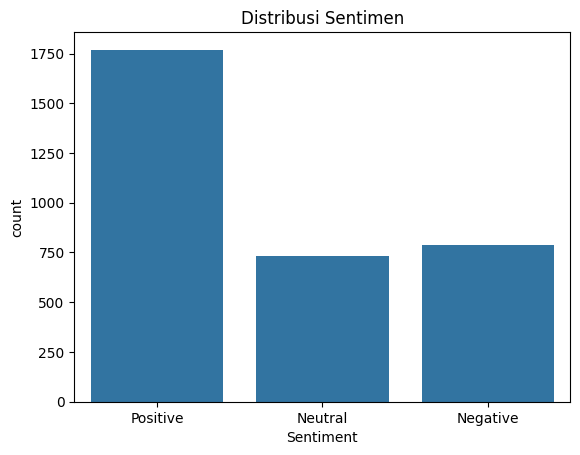

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="Sentiment", data=df)
plt.title("Distribusi Sentimen")
plt.show()

In [67]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # Hapus URL
    text = re.sub(r"@\w+", "", text)            # Hapus mention
    text = re.sub(r"#\w+", "", text)            # Hapus hashtag
    text = re.sub(r"[^\w\s]", "", text)         # Hapus tanda baca
    text = re.sub(r"\d+", "", text)             # Hapus angka
    return text.strip()

df["clean_text"] = df["Sentence"].apply(clean_text)


In [68]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["label_num"], test_size=0.2, random_state=42
)

# TF-IDF vektorisasi
vectorizer = TfidfVectorizer(max_features=3000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Naive Bayes
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# Prediksi & evaluasi
y_pred = model.predict(X_test_vec)
print(classification_report(y_test, y_pred, target_names=["Negative", "Neutral", "Positive"]))


              precision    recall  f1-score   support

    Negative       0.91      0.28      0.43       178
     Neutral       0.85      0.26      0.40       136
    Positive       0.61      0.99      0.75       344

    accuracy                           0.65       658
   macro avg       0.79      0.51      0.53       658
weighted avg       0.74      0.65      0.59       658



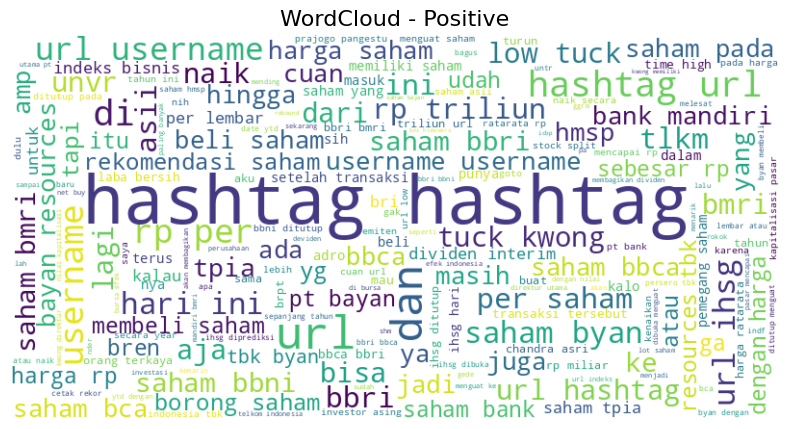

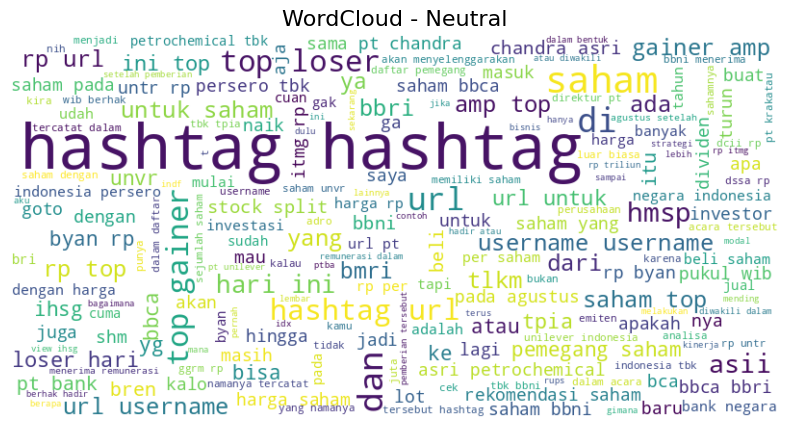

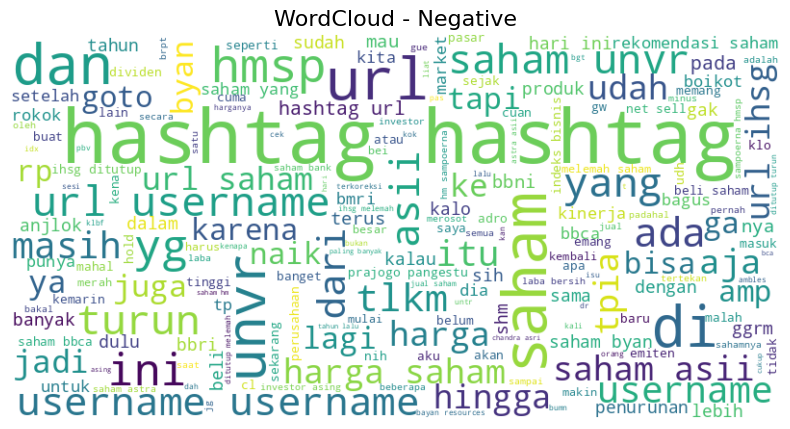

In [69]:
from wordcloud import WordCloud

# Pastikan kamu sudah install wordcloud
!pip install wordcloud

# Fungsi untuk plot WordCloud
def show_wordcloud(label, title):
    text = " ".join(df[df["Sentiment"] == label]["clean_text"])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# WordCloud untuk tiap sentimen
show_wordcloud("Positive", "WordCloud - Positive")
show_wordcloud("Neutral", "WordCloud - Neutral")
show_wordcloud("Negative", "WordCloud - Negative")


In [70]:
def predict_sentiment(text):
    clean = clean_text(text)
    vec = vectorizer.transform([clean])
    pred = model.predict(vec)[0]
    label_rev_map = {1: "Positive", 0: "Neutral", -1: "Negative"}
    return label_rev_map[pred]

# Coba prediksi
sample_text = "BCA naik terus mantap banget nih"
print("Prediksi Sentimen:", predict_sentiment(sample_text))


Prediksi Sentimen: Positive


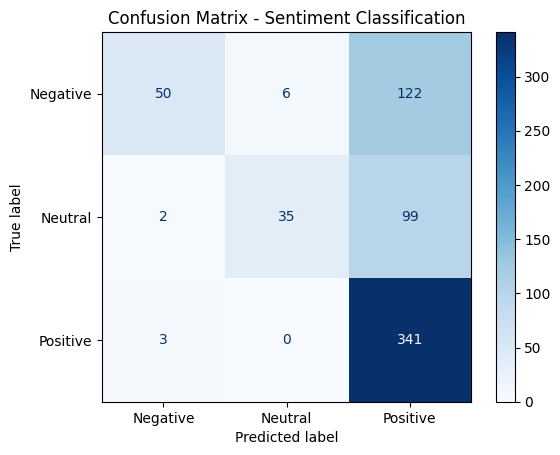

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Sentiment Classification")
plt.show()


In [72]:
# Gabungkan hasil prediksi dan aslinya
results_df = pd.DataFrame({
    "text": X_test,
    "actual": y_test,
    "predicted": y_pred
})

# Filter hanya yang salah
wrong_preds = results_df[results_df["actual"] != results_df["predicted"]]

# Tampilkan 10 contoh salah prediksi
wrong_preds.sample(10)


,text,actual,predicted
296,hashtag value rgregular market sedikit menyusu...,-1,1
3197,skandal yang menimpa daihatsu dan toyota menek...,-1,1
2707,market update笨ｨ ihsg melemah atau berkurang ...,-1,1
1660,username username saham gudang garam udah ting...,-1,1
1748,di sektor tembakau dan rokok hmsp dan ggrm men...,0,1
1814,ambles sepekan akankah saham byan bangkit usai...,0,1
2234,investor asing gencar obral saham asii bmri hi...,-1,1
432,saham unvr ini sejak kerjaannya cuma bikin ne...,-1,1
3157,username besaran dividen asii tahun ini kiraki...,0,1
2248,saham bank jumbo bbca bmri bbri bbni kompak lo...,-1,1


In [73]:
import numpy as np

# Prediksi semua teks di data uji
all_preds = model.predict(X_test_vec)
unique, counts = np.unique(all_preds, return_counts=True)

# Buat distribusi
sentiment_dist = dict(zip([{-1: "Negative", 0: "Neutral", 1: "Positive"}[u] for u in unique], counts))
sentiment_dist


{'Negative': np.int64(55), 'Neutral': np.int64(41), 'Positive': np.int64(562)}

In [74]:
!pip install dash dash-bootstrap-components --quiet


In [75]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd
import numpy as np
from google.colab import output # Import output for ngrok integration

# Removed redundant imports for TF-IDF and MultinomialNB as they are already in the environment

# --- Data and model from previous steps are already available ---
# df is already loaded and cleaned
# vectorizer is already fitted
# model is already trained

# Add prediction column to the existing df
df["prediction"] = model.predict(vectorizer.transform(df["clean_text"]))
rev_map = {1: "Positive", 0: "Neutral", -1: "Negative"} # Define rev_map here
df["pred_label"] = df["prediction"].map(rev_map)

# --- Start Dash App ---
app = dash.Dash(__name__, external_stylesheets=['https://cdn.jsdelivr.net/npm/bootstrap@5.1.3/dist/css/bootstrap.min.css'])

app.layout = html.Div([
    html.H1("📊 Dashboard Analisis Sentimen Sosial Media", style={'textAlign': 'center'}),

    html.Hr(),

    dcc.Dropdown(
        id='sentiment_filter',
        options=[
            {'label': 'All', 'value': 'all'},
            {'label': 'Positive', 'value': 'Positive'},
            {'label': 'Neutral', 'value': 'Neutral'},
            {'label': 'Negative', 'value': 'Negative'},
        ],
        value='all',
        placeholder="Pilih sentimen untuk filter",
    ),

    dcc.Graph(id='bar_chart'),

    html.H4("Contoh Tweet Berdasarkan Sentimen"),
    html.Div(id='tweet_examples')
])

@app.callback(
    [Output('bar_chart', 'figure'),
     Output('tweet_examples', 'children')],
    Input('sentiment_filter', 'value')
)
def update_output(selected):
    if selected == 'all':
        dff = df.copy()
    else:
        dff = df[df["pred_label"] == selected]

    fig = px.histogram(dff, x="pred_label", color="pred_label",
                       title="Distribusi Prediksi Sentimen",
                       color_discrete_map={"Positive": "green", "Neutral": "gray", "Negative": "red"})

    # Ensure there are enough samples to draw from
    num_samples = min(5, len(dff))
    if num_samples > 0:
        examples = dff.sample(num_samples)["Sentence"].tolist()
    else:
        examples = ["No tweets found for this sentiment."]

    return fig, html.Ul([html.Li(tweet) for tweet in examples])

# Jalankan aplikasi dengan ngrok di Colab
if __name__ == '__main__':
    # Use output.eval_js to get the ngrok URL
    output.eval_js('google.colab.output.setIframeHeight(0, true)')
    app.run(debug=False, port=8050)

<IPython.core.display.Javascript object>

In [76]:
# Install Git (opsional di Colab)
!apt-get install git -y


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [77]:
!git config --global user.name "junzy45"
!git config --global user.email "risjun445@gmail.com"


In [78]:
!git clone https://github.com/junzy45/analisis-sentimen.git

Cloning into 'analisis-sentimen'...


In [83]:
import shutil
import os

# Ensure the destination directory exists
# Change destination to the Git repository directory
destination_dir = "/content/analisis-sentimen"
os.makedirs(destination_dir, exist_ok=True)

# Copy the file from the correct location
shutil.copy("/content/IDSMSA (1).csv", os.path.join(destination_dir, "IDSMSA.csv"))
# Tambahkan file lain jika ada

'/content/analisis-sentimen/IDSMSA.csv'

In [84]:
%cd /content/analisis-sentimen
!git add .
!git commit -m "Upload hasil analisis sentimen dari Google Colab"
!git push


/content/analisis-sentimen
error: 'analisis-sentimen/' does not have a commit checked out
fatal: adding files failed
On branch main
Your branch is based on 'origin/main', but the upstream is gone.
  (use "git branch --unset-upstream" to fixup)

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	analisis-sentimen/

nothing added to commit but untracked files present (use "git add" to track)
fatal: could not read Username for 'https://github.com': No such device or address


In [57]:
%cd /content/analisis-sentimen
!git config --global user.email "risjun445@gmail.com"
!git config --global user.name "junzy45"
!git add .
!git commit -m "Upload hasil analisis sentimen dari Google Colab"
!git push -u origin main

/content/analisis-sentimen
On branch main
Your branch is based on 'origin/main', but the upstream is gone.
  (use "git branch --unset-upstream" to fixup)

nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address


In [59]:
!git remote add origin https://github.com/junzy45/analisis-sentimen.git
!git branch -M main
!git push -u origin main

error: remote origin already exists.
fatal: could not read Username for 'https://github.com': No such device or address
